## Analysis to classify land-use patterns from satelitte imagery

In [1]:
#import and proces libraries

import pandas as pd
import numpy as np
import os
from urllib.request import urlretrieve
from urllib.request import urlopen
from shutil import copyfileobj
from zipfile import ZipFile
import shutil
import glob

#from fastai import ImageClassifierData

from fastai.vision import *

#keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn import metrics

#visualization
import matplotlib.pyplot as plt

%pylab inline 

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/nfshome/cb4102/.conda/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['__version__', 'pad', 'random', 'partition', 'uniform', 'array', 'subplots', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data acquisition and pre-processing

In [39]:
#pull in data and unzip it

def get_data(url,file):
    '''function that searches for a zip file and if it's not in the cwd, grab zip from url and open it
    inputs:
    url - dict object with key=url and value=url_path
    file - name of the zip file'''
    
    file_list = os.listdir() #creates list of file names from cwd
    
    if file in file_list: #if file is in file list, unzip it
        with ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(os.getcwd())
    #if it isn't there, go download it and unzip it
    else:
        with urlopen(url) as in_stream, open(file, 'wb') as out_file:
            copyfileobj(in_stream, out_file)
        with ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(os.getcwd())

In [40]:
#get larger data set with all bands

#dictionary with URLs
image = {'url1': 'http://madm.dfki.de/files/sentinel/EuroSATallBands.zip',
         'url2': 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'}


#file1 = 'EuroSATallBands.zip' #larger file, all images and all types
#get_data(image['url1'],file1)

In [41]:
file2 = 'EuroSAT.zip' #smaller file, subset of images
get_data(image['url2'],file2)

In [14]:
#move images to data folder

folder_list = list(os.listdir('2750')) #list of subfolders 

dest = os.getcwd()+'/Data' #destination folder

for i in folder_list:
    files = os.listdir('2750/'+i) #file list in subfolder
    wd = os.getcwd()+'/2750/'+i+'/' #wd for files
    for f in files:
        shutil.move(wd+f, dest) #move files

In [17]:
#count the number of images in the data folder
print("There are {} images for classification".format(len(os.listdir('Data'))))

There are 27000 images for classification


In [ ]:
#download the data again to keep sub-folder structure for fastai 
file2 = 'EuroSAT.zip' #smaller file, subset of images
get_data(image['url2'],file2)

In [3]:
#display list of classes for reference
classes = list(os.listdir('2750'))
classes

['Forest',
 'Industrial',
 'Highway',
 'Residential',
 'AnnualCrop',
 'SeaLake',
 'PermanentCrop',
 'HerbaceousVegetation',
 'River',
 'Pasture']

In [39]:
#set data path object
path = Path(os.getcwd()+'/2750')

#since I don't have train and test subfolders I need to specify a validation cut
data = ImageDataBunch.from_folder(path,valid_pct=0.3)

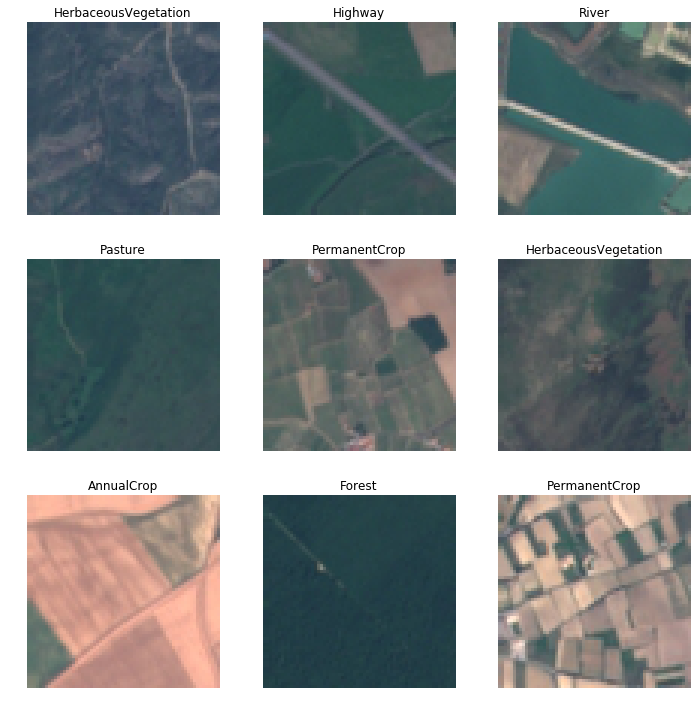

In [40]:
#visualize some examples of the images
data.show_batch(rows=3, figsize=(10,10))

### Basic FastAI modeling

In [41]:
learn = create_cnn(data, models.resnet34, metrics=accuracy) #initializes a CNN 
learn.fit_one_cycle(10) #10 epochs 

#learn.fit(lr, 1, wds=1e-4, use_wd_sched=True)

epoch,train_loss,valid_loss,accuracy
1,0.731303,0.486726,0.844321
2,0.445171,0.321766,0.892716
3,0.330858,0.247520,0.917161
4,0.258486,0.205372,0.931975
5,0.212108,0.175568,0.940247
6,0.165937,0.163002,0.946173
7,0.145971,0.151678,0.947901
8,0.129164,0.148710,0.950494
9,0.109777,0.145078,0.952469
10,0.108297,0.147087,0.950123


With minimal parameter tuning the model is already at an accuracy score of ~0.93

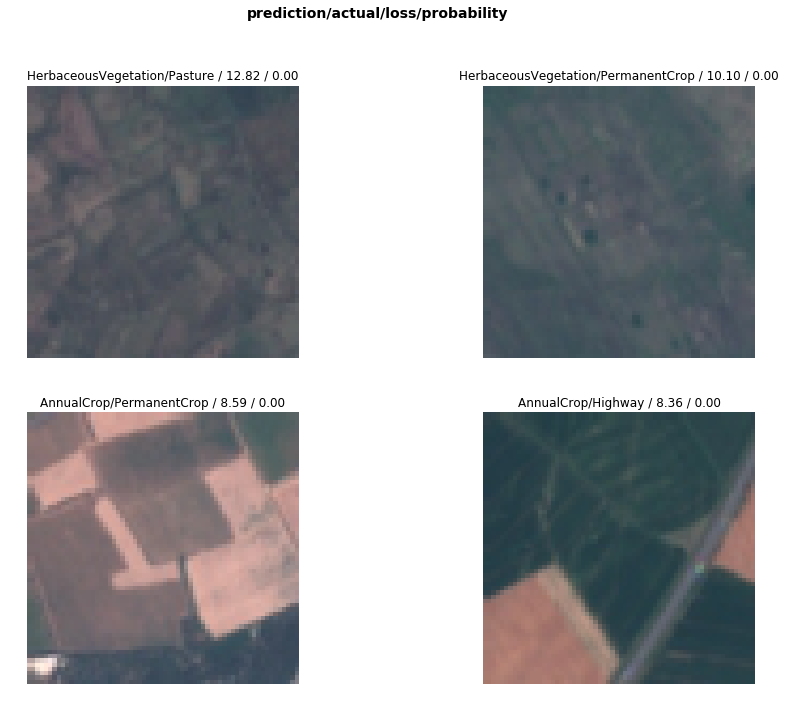

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(15, 11))

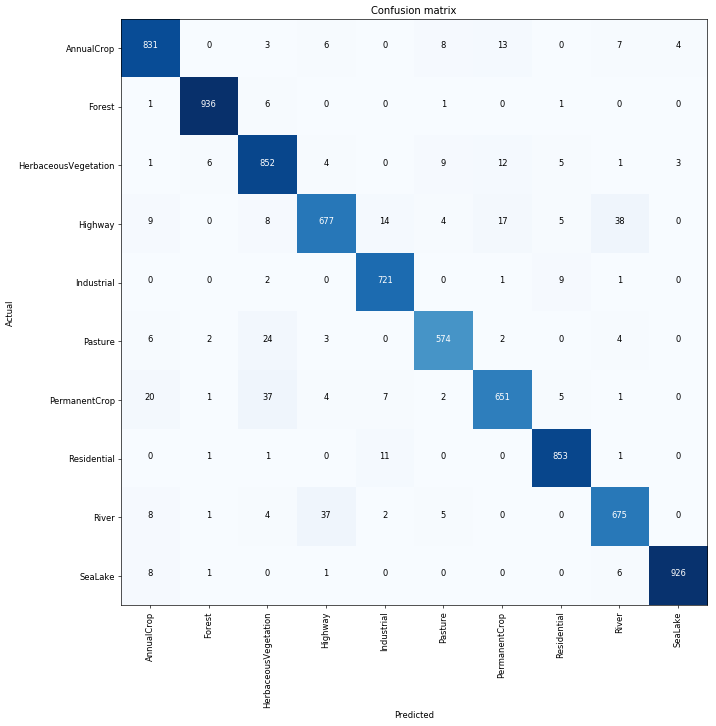

In [43]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [44]:
print("Pairs of images the model is struggling with:")
print(interp.most_confused(min_val=20))

Pairs of images the model is struggling with:
[('Highway', 'River', 38), ('PermanentCrop', 'HerbaceousVegetation', 37), ('River', 'Highway', 37), ('Pasture', 'HerbaceousVegetation', 24)]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


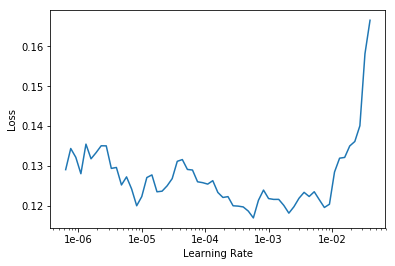

In [45]:
learn.lr_find()
learn.recorder.plot()